In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
# from sklearn.metrics import confusion_matrix
plt.style.use('seaborn')
sns.set(font_scale=1.5) 
from sklearn import model_selection

%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

# import torchvision.transforms.functional as transforms

In [2]:
df = pd.read_pickle("LSWMD.pkl")

In [3]:
df.info() #dataset check.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [4]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [5]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


In [6]:
df = df.drop(['waferIndex'], axis = 1)

In [7]:
#add wafermapDim column because waferMap dim is different each other.
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
167305,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3036.0,lot10661,[],[],"(64, 60)"
696453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...",516.0,lot42881,[[Training]],[[none]],"(25, 27)"
521110,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 1,...",515.0,lot32577,[],[],"(25, 27)"
314053,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4143.0,lot19154,[],[],"(70, 75)"
621833,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",712.0,lot39086,[],[],"(32, 29)"


In [8]:
#df_withlabel : labeled wafer
#df_withpattern : labeled & patterned wafer 
#df_nonpatter : labeled but non-patterned wafer
defined_df = df.loc[df['failureType'] != 0] #failureType !=0
defined_withpattern = defined_df[(defined_df['failureType'] != 'none')]
defined__withpattern = defined_withpattern.reset_index() #patterned index.
defined_nonpattern = defined_df[(defined_df['failureType'] == 'none')] #nonpatterned index
print('Total labeled data',defined_df.shape[0]) 
print('Data with defects',defined__withpattern.shape[0]) 
print('Data without defects',defined_nonpattern.shape[0])

D:\Anaconda\envs\tf\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


Total labeled data 172950
Data with defects 25519
Data without defects 147431


In [9]:
defined_df

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
...,...,...,...,...,...,...
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,[[Test]],[[Edge-Loc]],"(26, 30)"
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,[[Test]],[[Edge-Loc]],"(26, 30)"
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,[[Test]],[[Edge-Ring]],"(26, 30)"
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,[[Test]],[[Edge-Loc]],"(26, 30)"


In [10]:
defined_df['waferMapDim'].value_counts()

(25, 27)     18781
(26, 26)     14366
(30, 34)     12400
(29, 26)     11751
(27, 25)     10682
             ...  
(68, 72)         1
(29, 45)         1
(38, 62)         1
(43, 133)        1
(36, 41)         1
Name: waferMapDim, Length: 346, dtype: int64

# Reducing the size of None type data

In [11]:
df['failureNum']=defined_df.failureType
df['trainTestNum']=defined_df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [12]:
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()

In [13]:
np.unique(df_withlabel.failureNum, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
 array([  4294,    555,   5189,   9680,   3593,    866,   1193,    149,
        147431], dtype=int64))

In [14]:
df1 = defined_df[defined_df['failureType'] == 'none']

In [15]:
defined_df1 = defined_df[defined_df["failureType"] != 'none']

In [16]:
df_del = df1[::7]

In [17]:
defined_df = pd.concat([defined_df1,df_del])

# Final Data

In [18]:
defined_df

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[Loc]],"(45, 48)"
36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,[[Training]],[[Edge-Loc]],"(53, 58)"
37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,[[Training]],[[Edge-Loc]],"(53, 58)"
38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,[[Training]],[[Edge-Loc]],"(53, 58)"
39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,[[Training]],[[Edge-Loc]],"(53, 58)"
...,...,...,...,...,...,...
811403,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47540,[[Test]],[[none]],"(26, 30)"
811410,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47541,[[Test]],[[none]],"(26, 30)"
811417,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47541,[[Test]],[[none]],"(26, 30)"
811430,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2,...",600.0,lot47542,[[Test]],[[none]],"(26, 30)"


In [19]:
defined_df['failureType']

19             [[Loc]]
36        [[Edge-Loc]]
37        [[Edge-Loc]]
38        [[Edge-Loc]]
39        [[Edge-Loc]]
              ...     
811403        [[none]]
811410        [[none]]
811417        [[none]]
811430        [[none]]
811439        [[none]]
Name: failureType, Length: 46581, dtype: object

In [20]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cpu")

In [21]:
#extract specific dim
def subwafer(data, Dim0, Dim1):
  sw = torch.ones((1, Dim0, Dim1)).int()
  label = list()
  Dim0 = np.size(sw, axis=1)
  Dim1 = np.size(sw, axis=2)
  sub_df = data.loc[data['waferMapDim'] == (Dim0, Dim1)]
  sub_wafer = sub_df['waferMap'].values
  sw = sw.to(DEVICE)
  for i in range(len(sub_df)):
    waferMap = torch.from_numpy(sub_df.iloc[i,:]['waferMap'].reshape(1, Dim0, Dim1)).int()
    waferMap = waferMap.to(DEVICE)
    sw = torch.cat([sw, waferMap]) 
    label.append(sub_df.iloc[i,:]['failureType'][0][0])
  x = sw[1:]
  y = np.array(label).reshape((-1,1))
  del waferMap, sw
  return x, y

In [22]:
x, y = subwafer(defined_df,26,26)
x1, y1 = subwafer(defined_df, 25, 27)
x2, y2 = subwafer(defined_df, 30, 34)
x3, y3 = subwafer(defined_df, 29, 26)
x4, y4 = subwafer(defined_df, 27, 25)
x5, y5 = subwafer(defined_df, 39,37)
x6, y6 = subwafer(defined_df, 33,29)
x7, y7 = subwafer(defined_df, 42,44)
x8, y8 = subwafer(defined_df, 44,41)

In [23]:
x.shape, y.shape, x1.shape, y1.shape, x2.shape, y2.shape, x3.shape, y3.shape, x4.shape, y4.shape, x5.shape, y5.shape, x6.shape, y6.shape, x7.shape, y7.shape, x8.shape, y8.shape

(torch.Size([2803, 26, 26]),
 (2803, 1),
 torch.Size([5168, 25, 27]),
 (5168, 1),
 torch.Size([2381, 30, 34]),
 (2381, 1),
 torch.Size([2154, 29, 26]),
 (2154, 1),
 torch.Size([1747, 27, 25]),
 (1747, 1),
 torch.Size([2324, 39, 37]),
 (2324, 1),
 torch.Size([1504, 33, 29]),
 (1504, 1),
 torch.Size([1105, 42, 44]),
 (1105, 1),
 torch.Size([1390, 44, 41]),
 (1390, 1))

Number of donut inages each type is having

In [24]:
np.where(y1=='Donut'),np.where(y2=='Donut'),np.where(y3=='Donut'),np.where(y4=='Donut'),np.where(y5=='Donut'),np.where(y6=='Donut'),np.where(y7=='Donut'),np.where(y8=='Donut')

((array([], dtype=int64), array([], dtype=int64)),
 (array([216, 291, 658, 664], dtype=int64), array([0, 0, 0, 0], dtype=int64)),
 (array([478, 481], dtype=int64), array([0, 0], dtype=int64)),
 (array([ 49,  79, 158, 172, 228, 229], dtype=int64),
  array([0, 0, 0, 0, 0, 0], dtype=int64)),
 (array([   0,    1,    2,    3,  174,  631,  779,  925,  927,  932,  935,
          937,  945,  962,  968,  979,  980,  987,  989,  997, 1006, 1011],
        dtype=int64),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        dtype=int64)),
 (array([33, 97], dtype=int64), array([0, 0], dtype=int64)),
 (array([143], dtype=int64), array([0], dtype=int64)),
 (array([ 13,  19,  21,  33, 380, 382, 530, 531, 540, 580, 581, 582],
        dtype=int64),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)))

# viewing the dataset images

Text(0.5, 1.0, 'None')

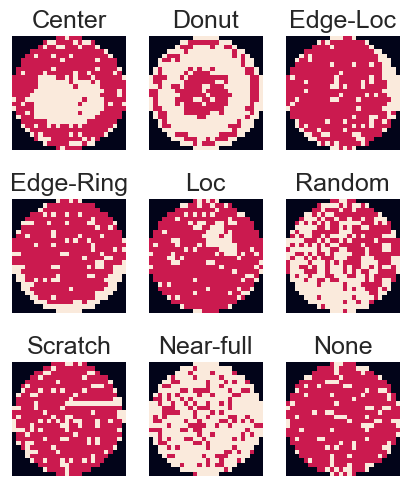

In [25]:
fig, ax = plt.subplots(3,3, figsize = (5,6))
ax[0][0].imshow(x[np.where(y=='Center')[0][20]].to('cpu'))
ax[0][0].set_title("Center")
ax[0][0].axis("off")
ax[0][1].imshow(x[np.where(y=='Donut')[0][0]].to('cpu'))
ax[0][1].axis("off")
ax[0][1].set_title("Donut")
ax[0][2].imshow(x[np.where(y=='Edge-Loc')[0][100]].to('cpu'))
ax[0][2].axis("off")
ax[0][2].set_title("Edge-Loc")
ax[1][0].imshow(x[np.where(y=='Edge-Ring')[0][20]].to('cpu'))
ax[1][0].axis("off")
ax[1][0].set_title("Edge-Ring")
ax[1][1].imshow(x[np.where(y=='Loc')[0][15]].to('cpu'))
ax[1][1].axis("off")
ax[1][1].set_title("Loc")
ax[1][2].imshow(x[np.where(y=='Random')[0][20]].to('cpu'))
ax[1][2].axis("off")
ax[1][2].set_title("Random")
ax[2][0].imshow(x[np.where(y=='Scratch')[0][20]].to('cpu'))
ax[2][0].axis("off")
ax[2][0].set_title("Scratch")
ax[2][1].imshow(x[np.where(y=='Near-full')[0][1]].to('cpu'))
ax[2][1].axis("off")
ax[2][1].set_title("Near-full")
ax[2][2].imshow(x[np.where(y=='none')[0][0]].to('cpu'))
ax[2][2].axis("off")
ax[2][2].set_title("None")

# One hot encoding

In [26]:
#add RGB space for one-hot encoding
# 0: non wafer -> R, 1: normal die -> G, 2: defect die -> B|

def rgb_sw(x):
  Dim0 = np.size(x, axis=1)
  Dim1 = np.size(x, axis=2)
  new_x = np.zeros((len(x), Dim0, Dim1, 3))
  x = torch.unsqueeze(x,-1)
  x = x.to(torch.device('cpu'))
  x = x.numpy()
  for w in range(len(x)): 
      for i in range(Dim0):
          for j in range(Dim1):
              new_x[w, i, j, int(x[w, i, j])] = 1
  return new_x

In [27]:
rgb_x0 = rgb_sw(x1) 
rgb_x1 = rgb_sw(x2)

In [28]:
rgb_x2 = rgb_sw(x3)
rgb_x3 = rgb_sw(x4)

In [29]:
rgb_x4 = rgb_sw(x5)
rgb_x5 = rgb_sw(x8)

# Resizing images to (26,26,3)

In [30]:
def resize(x):
  rwm = torch.ones((1,26,26,3))
  for i in range(len(x)):
    rwm = rwm.to(torch.device('cpu'))
    a = Image.fromarray(x[i].astype('uint8')).resize((26,26))
    a = np.array(a).reshape((1,26,26,3))
    a = torch.from_numpy(a).float()
    a = a.to(torch.device('cpu'))
    rwm = torch.cat([rwm, a])
  x = rwm[1:]
  del rwm
  return x

In [31]:
resized_x0 = resize(rgb_x0)
resized_x1 = resize(rgb_x1)

In [32]:
resized_x2 = resize(rgb_x2)
resized_x3 = resize(rgb_x3)

In [33]:
resized_x4 = resize(rgb_x4)
resized_x5 = resize(rgb_x5)

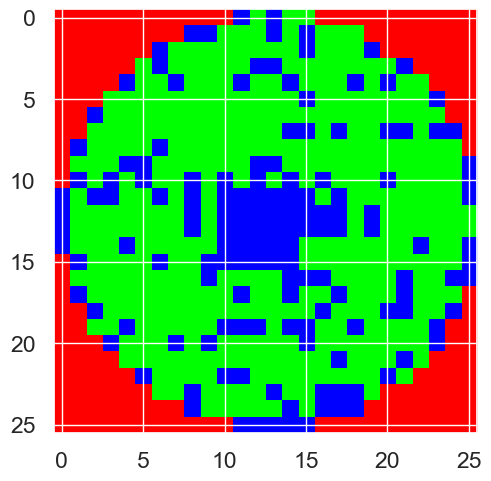

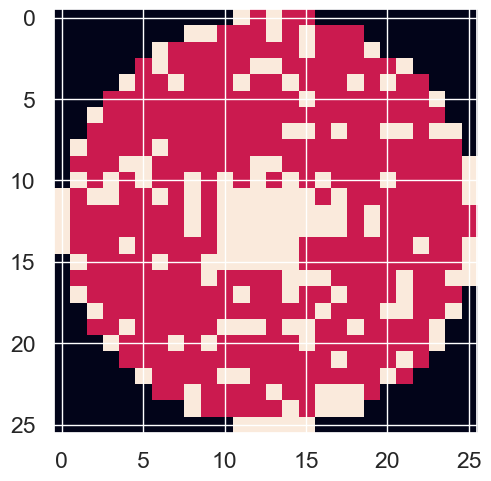

In [34]:
plt.imshow(resized_x0[1000])
plt.show()
plt.imshow(np.argmax(resized_x0[1000],axis=2).cpu().numpy())
plt.show()

In [35]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [36]:
resized_wm = torch.cat([resized_x0, resized_x1,resized_x2,resized_x3,resized_x4,resized_x5])
label_wm = np.concatenate((y1,y2,y3,y4,y5,y8)) 

In [37]:
label_wm.shape

(15164, 1)

In [38]:
for i, l in enumerate(faulty_case):
    label_wm[label_wm==l] = i    
    print('i : {}, l : {}'.format(i, l))
def _to_one_hot(y, num_classes):
    scatter_dim = len(y.size())
    y_tensor = y.view(*y.size(), -1)
    zeros = torch.zeros(*y.size(), num_classes, dtype=y.dtype)
    return zeros.scatter(scatter_dim, y_tensor, 1)

label_wm = _to_one_hot(torch.as_tensor(np.int64(label_wm)), num_classes=9)

i : 0, l : Center
i : 1, l : Donut
i : 2, l : Edge-Loc
i : 3, l : Edge-Ring
i : 4, l : Loc
i : 5, l : Near-full
i : 6, l : Random
i : 7, l : Scratch
i : 8, l : none


In [39]:
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(resized_wm, label_wm , test_size=0.2)

# Building CNN

In [40]:
train_X = train_X.numpy()

In [41]:
train_Y = train_Y.numpy()

In [42]:
test_X = test_X.numpy()

In [43]:
test_Y = test_Y.numpy()

reshaping Y to fit model

In [44]:
train_Y = train_Y.reshape((train_Y.shape[0], train_Y.shape[2]))

In [45]:
test_Y = test_Y.reshape((test_Y.shape[0], test_Y.shape[2]))

In [46]:
model = Sequential()
model.add(Conv2D(32,(4,4),activation='relu',input_shape=(26,26,3)))
model.add(Conv2D(32,(4,4),activation='relu', padding='same'))
model.add(Conv2D(128,(4,4),activation='relu', padding='same'))
model.add(Conv2D(128,(4,4),activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(.3))
model.add(Conv2D(256, (4,4), activation='relu', padding='same'))
model.add(Conv2D(256, (4,4), activation='relu', padding='same'))
model.add(Conv2D(128, (4,4), activation='relu', padding='same'))
model.add(Conv2D(128, (4,4), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(.3))
model.add(MaxPooling2D((2, 2)))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(.3))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(9, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 23, 23, 32)        1568      
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 32)        16416     
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       65664     
                                                                 
 conv2d_3 (Conv2D)           (None, 23, 23, 128)       262272    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 128)       0         
                                                        

In [47]:
# compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
# setting upearly stopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [48]:
# defining early stopping so that we don't overfit
# also we reduce the learning rate so that we can fit properly
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, 
                                            min_lr=0.00001)

In [49]:
callbacks = [earlystop, learning_rate_reduction]

In [50]:
history = model.fit(train_X, train_Y,
                      batch_size=500, epochs=100,
                      validation_data=(test_X, test_Y),callbacks=callbacks)

Epoch 1/100
25/25 [==============================] - 103s 4s/step - loss: 3.0430 - accuracy: 0.4077 - val_loss: 1.2508 - val_accuracy: 0.6057 - lr: 0.0010
Epoch 2/100
25/25 [==============================] - 111s 4s/step - loss: 1.4097 - accuracy: 0.6301 - val_loss: 1.2345 - val_accuracy: 0.7521 - lr: 0.0010
Epoch 3/100
25/25 [==============================] - 101s 4s/step - loss: 1.1123 - accuracy: 0.7279 - val_loss: 0.8704 - val_accuracy: 0.7699 - lr: 0.0010
Epoch 4/100
25/25 [==============================] - 102s 4s/step - loss: 0.8742 - accuracy: 0.7647 - val_loss: 0.9253 - val_accuracy: 0.7755 - lr: 0.0010
Epoch 5/100
25/25 [==============================] - 102s 4s/step - loss: 0.8208 - accuracy: 0.7839 - val_loss: 0.6824 - val_accuracy: 0.8042 - lr: 0.0010
Epoch 6/100
25/25 [==============================] - 100s 4s/step - loss: 0.7787 - accuracy: 0.7904 - val_loss: 0.6382 - val_accuracy: 0.8216 - lr: 0.0010
Epoch 7/100
25/25 [==============================] - 104s 4s/step - lo

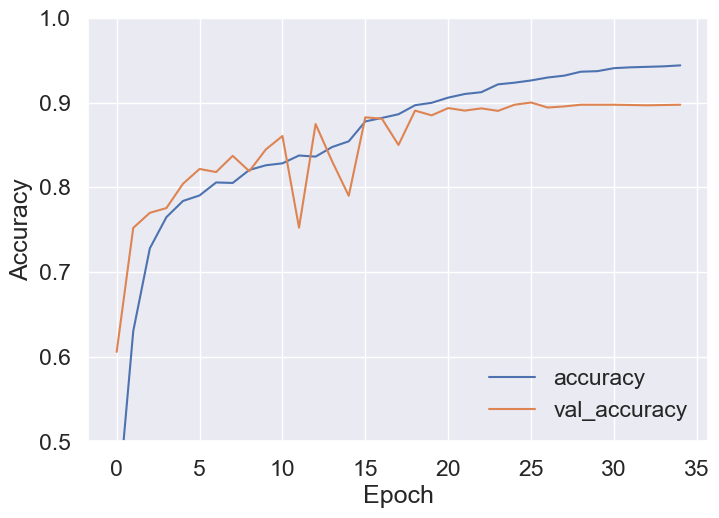

In [51]:
# Plotting the training and validation results
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# Using 4 fold CV

In [52]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32,(4,4),activation='relu',input_shape=(26,26,3)))
    model.add(Conv2D(32,(4,4),activation='relu', padding='same'))
    model.add(Conv2D(128,(4,4),activation='relu', padding='same'))
    model.add(Conv2D(128,(4,4),activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(.3))
    model.add(Conv2D(256, (4,4), activation='relu', padding='same'))
    model.add(Conv2D(256, (4,4), activation='relu', padding='same'))
    model.add(Conv2D(128, (4,4), activation='relu', padding='same'))
    model.add(Conv2D(128, (4,4), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(.3))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.3))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(9, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
    return model
    

In [53]:

model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=4, shuffle=True, random_state=2019) 
results = cross_val_score(model, train_X, train_Y, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

D:\Anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


Epoch 1/50
9/9 - 62s - loss: 8.7952 - accuracy: 0.3371 - 62s/epoch - 7s/step
Epoch 2/50
9/9 - 60s - loss: 1.4291 - accuracy: 0.6023 - 60s/epoch - 7s/step
Epoch 3/50
9/9 - 60s - loss: 1.3406 - accuracy: 0.6168 - 60s/epoch - 7s/step
Epoch 4/50
9/9 - 59s - loss: 1.2030 - accuracy: 0.7004 - 59s/epoch - 7s/step
Epoch 5/50
9/9 - 60s - loss: 1.0856 - accuracy: 0.7259 - 60s/epoch - 7s/step
Epoch 6/50
9/9 - 60s - loss: 0.8275 - accuracy: 0.7664 - 60s/epoch - 7s/step
Epoch 7/50
9/9 - 61s - loss: 0.8505 - accuracy: 0.7692 - 61s/epoch - 7s/step
Epoch 8/50
9/9 - 62s - loss: 0.7800 - accuracy: 0.7856 - 62s/epoch - 7s/step
Epoch 9/50
9/9 - 62s - loss: 0.7917 - accuracy: 0.7775 - 62s/epoch - 7s/step
Epoch 10/50
9/9 - 62s - loss: 0.7072 - accuracy: 0.7959 - 62s/epoch - 7s/step
Epoch 11/50
9/9 - 63s - loss: 0.7601 - accuracy: 0.7919 - 63s/epoch - 7s/step
Epoch 12/50
9/9 - 63s - loss: 0.7147 - accuracy: 0.8049 - 63s/epoch - 7s/step
Epoch 13/50
9/9 - 63s - loss: 0.6720 - accuracy: 0.8107 - 63s/epoch - 7s/

# Applying other algorithms

1. SVC
2. Decision Tree
3. Random Forest
4. ADA Boost
5. Gradient Boosting
6. BAGGING ENSEMBLE MODEL
7. K means
8. XG Boost
9. KNN

In [54]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier,BaggingRegressor
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier


Preparing the data again in 2d 

In [55]:
label_wm_new = np.concatenate((y1,y2,y3,y4,y5,y8))

In [56]:
label_wm_new

array([['Edge-Loc'],
       ['Edge-Loc'],
       ['Edge-Loc'],
       ...,
       ['none'],
       ['none'],
       ['none']], dtype='<U9')

In [57]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(label_wm_new)
print(integer_encoded)


[2 2 2 ... 8 8 8]


D:\Anaconda\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [58]:
label_encoder.inverse_transform(integer_encoded)

array(['Edge-Loc', 'Edge-Loc', 'Edge-Loc', ..., 'none', 'none', 'none'],
      dtype='<U9')

In [59]:
train_X1, test_X1, train_Y1, test_Y1 = model_selection.train_test_split(resized_wm, integer_encoded , test_size=0.2)

In [60]:
train_X1 = train_X1.numpy()
test_X1 = test_X1.numpy()

In [61]:
trainnew1 = train_X1.reshape(12131 , 2028)

In [62]:
testnew1 = test_X1.reshape(3033 , 2028)

# Applying SVC

In [63]:
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(trainnew1, train_Y1)

SVC(kernel='linear', random_state=0)

In [64]:
y_pred = classifier.predict(testnew1)
print(np.concatenate((y_pred.reshape(len(y_pred),1), test_Y1.reshape(len(test_Y1),1)),1))


[[2 8]
 [8 8]
 [8 8]
 ...
 [8 8]
 [8 8]
 [0 0]]


[[ 480    0    1    0    9    0    0    0   26]
 [   0    4    1    0    5    0    0    1    0]
 [   1    0  253    6    9    0    2    6  104]
 [   0    0   13    7    0    0    0    0    1]
 [   7    1   23    0   41    0    1    9  102]
 [   0    0    0    0    0   16    0    0    0]
 [   0    1   10    0    2    1   10    1    0]
 [   2    0    5    0    5    0    0    3   26]
 [  28    0  103    2   42    0    0   29 1634]]


0.8071216617210683

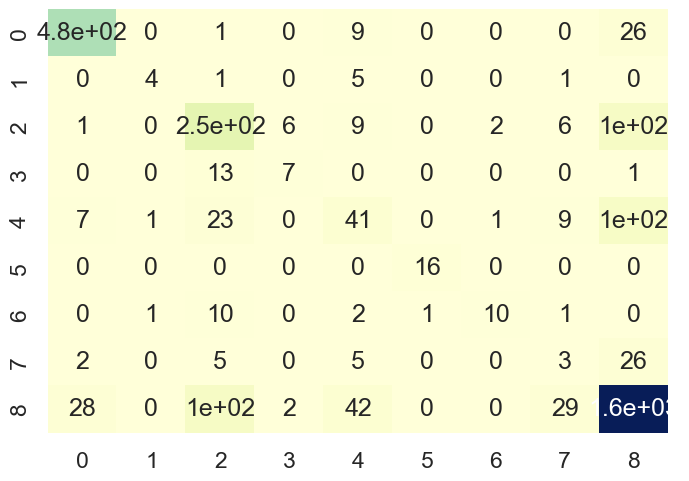

In [65]:
cm = confusion_matrix(test_Y1, y_pred)
sns.heatmap(cm,cmap='YlGnBu', annot = True,cbar = False)
print(cm)
accuracy_score(test_Y1, y_pred)

In [87]:

classifier = SVC(kernel = 'poly', random_state = 0)
classifier.fit(trainnew1, train_Y1)

SVC(kernel='poly', random_state=0)

In [88]:
y_pred = classifier.predict(testnew1)
print(np.concatenate((y_pred.reshape(len(y_pred),1), test_Y1.reshape(len(test_Y1),1)),1))


[[8 8]
 [8 8]
 [8 8]
 ...
 [8 8]
 [8 8]
 [8 0]]


[[ 473    0    2    0    5    0    0    0   36]
 [   0    3    0    0    7    0    1    0    0]
 [   1    0  245    3    8    0    2    0  122]
 [   0    0   11    9    0    0    0    0    1]
 [   3    1   18    0   41    0    0    0  121]
 [   0    0    0    0    0   16    0    0    0]
 [   0    1    8    0    2    1   13    0    0]
 [   0    0    5    0    3    0    0    0   33]
 [   7    0   58    1   15    0    0    0 1757]]


0.8430596768875701

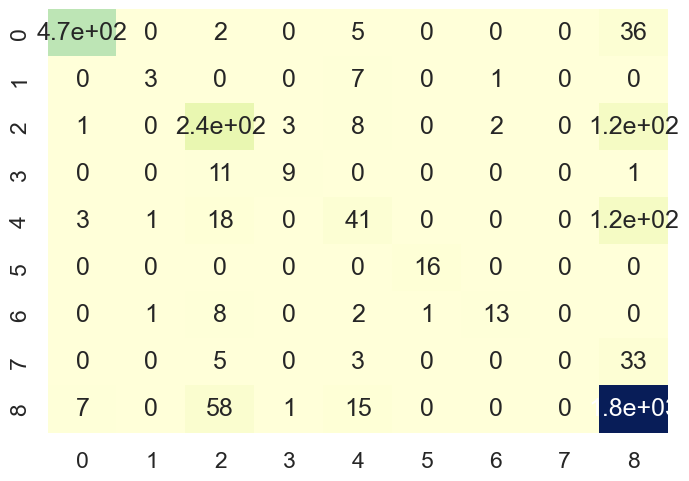

In [89]:
cm = confusion_matrix(test_Y1, y_pred)
sns.heatmap(cm,cmap='YlGnBu', annot = True,cbar = False)
print(cm)
accuracy_score(test_Y1, y_pred)

# APPLYING DECISION TREE

In [66]:
# Creating Decision Tree Classifier
clf = DecisionTreeClassifier(random_state = 0)
clf.fit(trainnew1, train_Y1)

# Predict Accuracy Score
y_pred = clf.predict(testnew1)
print("Train data accuracy:",accuracy_score(y_true = train_Y1, y_pred=clf.predict(trainnew1)))
print("Test data accuracy:",accuracy_score(y_true = test_Y1, y_pred=y_pred))

Train data accuracy: 1.0
Test data accuracy: 0.7138147049126278


In [67]:
print("Confusion Matrix:")
print(confusion_matrix(test_Y1, y_pred))

print("Classification Report")
print(classification_report(test_Y1, y_pred))

Confusion Matrix:
[[ 443    0   10    0   10    0    4    0   49]
 [   1    0    3    0    2    0    1    2    2]
 [  14    0  172   14   22    3    3    2  151]
 [   1    0    8    7    0    1    1    1    2]
 [  13    0   23    0   36    0    0   10  102]
 [   0    0    2    0    1   10    3    0    0]
 [   1    0    9    0    5    0    6    2    2]
 [   2    0    9    1    4    0    0    1   24]
 [  29    1  164    8  108    0    2   36 1490]]
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       516
           1       0.00      0.00      0.00        11
           2       0.43      0.45      0.44       381
           3       0.23      0.33      0.27        21
           4       0.19      0.20      0.19       184
           5       0.71      0.62      0.67        16
           6       0.30      0.24      0.27        25
           7       0.02      0.02      0.02        41
           8       0.82      0.81      0

# APPLYING RANDOM FOREST

In [68]:
clf_rand = RandomForestClassifier(n_estimators=3, max_features="auto",random_state=0)
clf_rand.fit(trainnew1, train_Y1)
y_pred = clf_rand.predict(testnew1)
print("Train data accuracy:",accuracy_score(y_true = train_Y1, y_pred=clf_rand.predict(trainnew1)))
print("Test data accuracy:",accuracy_score(y_true = test_Y1, y_pred=y_pred))

Train data accuracy: 0.9466655675542
Test data accuracy: 0.7303000329706562


In [69]:
print("Confusion Matrix:")
print(confusion_matrix(test_Y1, y_pred))

print("Classification Report")
print(classification_report(test_Y1, y_pred))

Confusion Matrix:
[[ 454    0    4    1   10    0    0    0   47]
 [   2    0    2    0    1    0    0    0    6]
 [  29    1  144    3    7    0    0    2  195]
 [   2    0   10    6    0    0    0    0    3]
 [  14    3   30    0   15    0    0    0  122]
 [   1    2    3    0    1    9    0    0    0]
 [   5    0    9    0    1    1    4    0    5]
 [   1    0    6    0    1    0    0    4   29]
 [  71    5  144    4   34    0    0    1 1579]]
Classification Report
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       516
           1       0.00      0.00      0.00        11
           2       0.41      0.38      0.39       381
           3       0.43      0.29      0.34        21
           4       0.21      0.08      0.12       184
           5       0.90      0.56      0.69        16
           6       1.00      0.16      0.28        25
           7       0.57      0.10      0.17        41
           8       0.80      0.86      0

# APPLYING ADABOOST


In [70]:
clf_ada = AdaBoostClassifier(n_estimators=3)
clf_ada.fit(trainnew1, train_Y1)
y_pred = clf_ada.predict(testnew1)
print("Train data accuracy:",accuracy_score(y_true = train_Y1, y_pred=clf_ada.predict(trainnew1)))
print("Test data accuracy:",accuracy_score(y_true = test_Y1, y_pred=y_pred))

Train data accuracy: 0.7463523205011953
Test data accuracy: 0.7467853610286844


In [71]:
print("Confusion Matrix:")
print(confusion_matrix(test_Y1, y_pred))

print("Classification Report")
print(classification_report(test_Y1, y_pred))

Confusion Matrix:
[[ 427    0    0    0    0    0    0    0   89]
 [   0    0    0    0    0    0    0    0   11]
 [  23    0    0    0    0    0    0    0  358]
 [   4    0    0    0    0    0    0    0   17]
 [   2    0    0    0    0    0    0    0  182]
 [   0    0    0    0    0    0    0    0   16]
 [   3    0    0    0    0    0    0    0   22]
 [   2    0    0    0    0    0    0    0   39]
 [   0    0    0    0    0    0    0    0 1838]]
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.83      0.87       516
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00       381
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00       184
           5       0.00      0.00      0.00        16
           6       0.00      0.00      0.00        25
           7       0.00      0.00      0.00        41
           8       0.71      1.00      0

D:\Anaconda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# APPLYING GRADIENT BOOSTING

In [72]:
clf_grad = GradientBoostingClassifier(n_estimators=5)
clf_grad.fit(trainnew1, train_Y1)
y_pred = clf_grad.predict(testnew1)
print("Train data accuracy:",accuracy_score(y_true = train_Y1, y_pred=clf_grad.predict(trainnew1)))
print("Test data accuracy:",accuracy_score(y_true = test_Y1, y_pred=y_pred))

Train data accuracy: 0.7519577940812794
Test data accuracy: 0.7464556544675239


In [73]:
print("Confusion Matrix:")
print(confusion_matrix(test_Y1, y_pred))

print("Classification Report")
print(classification_report(test_Y1, y_pred))

Confusion Matrix:
[[ 424    1    0    0    0    3    0    0   88]
 [   0    0    0    0    0    1    0    0   10]
 [  15    0    0    1    0    1    0    0  364]
 [   3    0    0    1    0    0    0    0   17]
 [   0    1    0    1    0    1    0    1  180]
 [   0    2    0    0    0   11    1    0    2]
 [   2    0    0    1    0    6    0    0   16]
 [   2    0    0    0    0    0    0    0   39]
 [   0    3    0    5    0    2    0    0 1828]]
Classification Report
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       516
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00       381
           3       0.11      0.05      0.07        21
           4       0.00      0.00      0.00       184
           5       0.44      0.69      0.54        16
           6       0.00      0.00      0.00        25
           7       0.00      0.00      0.00        41
           8       0.72      0.99      0

D:\Anaconda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# APPLYING BAGGING ENSEMBLE MODEL

In [74]:
clf_bagging = BaggingClassifier(n_estimators=3)
clf_bagging.fit(trainnew1, train_Y1)
y_pred = clf_bagging.predict(testnew1)
print("Train data accuracy:",accuracy_score(y_true = train_Y1, y_pred=clf_bagging.predict(trainnew1)))
print("Test data accuracy:",accuracy_score(y_true = test_Y1, y_pred=y_pred))

Train data accuracy: 0.9505399389992581
Test data accuracy: 0.7556874381800198


In [75]:
print("Confusion Matrix:")
print(confusion_matrix(test_Y1, y_pred))

print("Classification Report")
print(classification_report(test_Y1, y_pred))

Confusion Matrix:
[[ 464    0    6    0    5    0    0    1   40]
 [   2    0    1    0    2    0    0    0    6]
 [  29    1  193    6    6    1    3    2  140]
 [   2    0    8    6    0    0    0    0    5]
 [  14    2   32    1   17    0    0    1  117]
 [   0    0    3    0    2    9    2    0    0]
 [   3    0    9    0    6    1    2    0    4]
 [   1    0    3    0    3    0    0    3   31]
 [  47    9  126    2   52    0    1    3 1598]]
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       516
           1       0.00      0.00      0.00        11
           2       0.51      0.51      0.51       381
           3       0.40      0.29      0.33        21
           4       0.18      0.09      0.12       184
           5       0.82      0.56      0.67        16
           6       0.25      0.08      0.12        25
           7       0.30      0.07      0.12        41
           8       0.82      0.87      0

# K means

In [76]:
wcss = []
for i in range(1, 50):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(trainnew1)
    wcss.append(kmeans.inertia_)

Minimum error:- 1413607.5 at K = 48


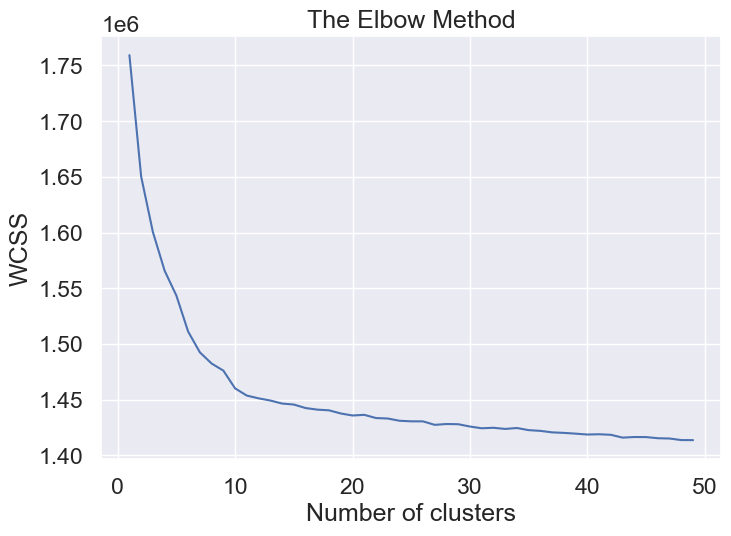

In [77]:
print("Minimum error:-",min(wcss),"at K =",wcss.index(min(wcss)))
plt.plot(range(1, 50), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [78]:
kmeans = KMeans(n_clusters = 9, init = 'k-means++', random_state = 42)
y_train = kmeans.fit(trainnew1)
y_pred = kmeans.fit_predict(testnew1)

In [79]:
print("Train data accuracy:",accuracy_score(y_true = train_Y1, y_pred=kmeans.predict(trainnew1)))
print("Test data accuracy:",accuracy_score(y_true = test_Y1, y_pred=y_pred))

Train data accuracy: 0.04830599291072459
Test data accuracy: 0.043521266073194856


In [80]:
print(np.concatenate((y_pred.reshape(len(y_pred),1), test_Y1.reshape(len(test_Y1),1)),1))

[[7 8]
 [4 8]
 [7 8]
 ...
 [5 8]
 [2 8]
 [4 0]]


# XGBoost

In [81]:
classifier = XGBClassifier()
classifier.fit(trainnew1, train_Y1)
y_pred = classifier.predict(testnew1)
print("Train data accuracy:",accuracy_score(y_true = train_Y1, y_pred=classifier.predict(trainnew1)))
print("Test data accuracy:",accuracy_score(y_true = test_Y1, y_pred=y_pred))

Train data accuracy: 0.9997526996949962
Test data accuracy: 0.8532805802835477


In [82]:
print("Confusion Matrix:")
print(confusion_matrix(test_Y1, y_pred))

print("Classification Report")
print(classification_report(test_Y1, y_pred))

Confusion Matrix:
[[ 470    0    0    0    6    0    0    0   40]
 [   0    0    3    0    8    0    0    0    0]
 [   1    0  248    4    9    0    0    0  119]
 [   0    0   12    8    0    0    0    0    1]
 [   7    1   16    0   34    0    0    0  126]
 [   0    0    1    0    0   10    5    0    0]
 [   0    0   10    0    8    0    6    0    1]
 [   2    0    0    0    1    0    0    1   37]
 [   4    0   16    1    5    0    0    1 1811]]
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       516
           1       0.00      0.00      0.00        11
           2       0.81      0.65      0.72       381
           3       0.62      0.38      0.47        21
           4       0.48      0.18      0.27       184
           5       1.00      0.62      0.77        16
           6       0.55      0.24      0.33        25
           7       0.50      0.02      0.05        41
           8       0.85      0.99      0

In [83]:
accuracies = cross_val_score(estimator = classifier, X = trainnew1, y = train_Y1, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 84.39 %
Standard Deviation: 0.48 %


# KNN

In [84]:
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
y_kmeans = classifier.fit(trainnew1, train_Y1)

In [85]:
y_pred = classifier.predict(testnew1)
print(np.concatenate((y_pred.reshape(len(y_pred),1), test_Y1.reshape(len(test_Y1),1)),1))

[[8 8]
 [4 8]
 [8 8]
 ...
 [4 8]
 [8 8]
 [4 0]]


confussion matrix: 
 [[ 375    0    1    0   62    0    0    0   78]
 [   0    3    1    0    1    0    0    0    6]
 [   5    0   75    4   15    1    0    0  281]
 [   0    0    7   10    0    0    0    0    4]
 [   1    1    4    0   19    0    0    0  159]
 [   0    0    0    0    0   16    0    0    0]
 [   5    0    5    0    0    4    0    0   11]
 [   1    0    1    0    0    0    0    0   39]
 [   6    0   10    1  344    0    0    0 1477]]
Accuracy score :  0.6511704582921201
Classification report : 
               precision    recall  f1-score   support

           0       0.95      0.73      0.83       516
           1       0.75      0.27      0.40        11
           2       0.72      0.20      0.31       381
           3       0.67      0.48      0.56        21
           4       0.04      0.10      0.06       184
           5       0.76      1.00      0.86        16
           6       0.00      0.00      0.00        25
           7       0.00      0.00      0.00       

D:\Anaconda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


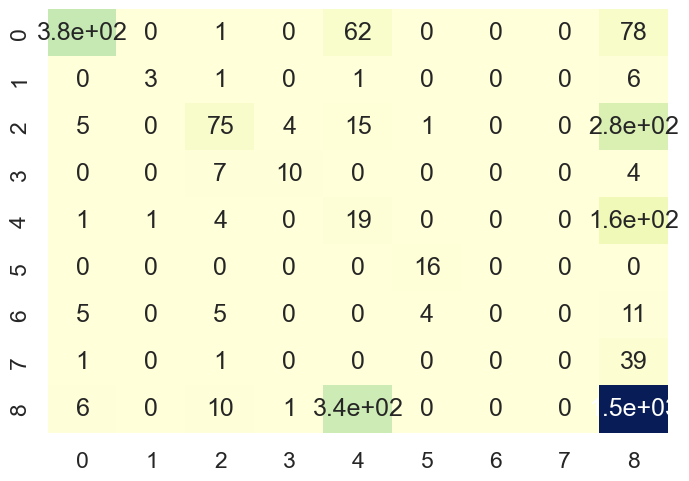

In [86]:
# Making the Confusion Matrix
cm = confusion_matrix(test_Y1, y_pred)
sns.heatmap(cm,cmap='YlGnBu', annot = True,cbar = False)
print('confussion matrix: \n',cm)
print('Accuracy score : ',accuracy_score(test_Y1, y_pred))
print('Classification report : \n',classification_report(test_Y1,y_pred))